# Getting Started with Disentangling Flow Models

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Manifold%20Disentanglement%20Cartoon.png?raw=true" alt="drawing" width="1024"/>

## Problem Statement
Suppose you have a collection of data-points, each defined in some multi-dimensional space that is difficult to visualize or edit. Yet, you suspect that the data points have an underlying structure that can be described by some human-interpretable factors. For instance, you might be working with an artificial neural network that classifies stimuli and trying to explain its internal representations. In the case of
- images that capture people's faces, the latent representations might express the color of the eyes, the size of the nose or the style of the hair.
- recordings of people's voices, the latent representations might express the speaker's identity (e.g. male or female) or their mood (e.g. happy or sad).
- recordings of environmental sounds, the latent representations might capture the sound source's material and action properties.
 
All these examples have in common that the data-points form a cloud, also known as manifold and likely cluster along trajectories that correspond to the interpretable factors. To test for this hypothesis, we need to project the manifold to a lower dimensional space where it can be visualized and systematically edited. 


## Standard Solutions
While linear projection methods such as principal component analysis are widely used, they only allow to reshape a manifold by moving, shearing, flipping or rotating it. Apart from that, it is biased towards the dominant axes of variance, while these might not always be the factors of interest to you. More advanced non-linear projection methods like t-distributed stochastic neighborhood embeddings (t-SNE), uniform manifold approximations and projections (UMAPs) or auto-encoders can assimilate the morphing space that is pronounced more in some regions than others. However, t-SNE and UMAP are not invertible and auto-encoders would need a mirrored version of themselves to approximate their own inverse which requires more model parameters, training resources and is not exact.

## Disentangling Flow Models
### Flow Models in General
Flow models are invertible artificial neural networks that can be used for various tasks including regression, probability densitiy estimation and latent factor disentanglement. Similar to regular neural networks, flow networks can be used for classification, as has been shown for instance for optical character recognition [[4](#References)]. Yet, the real contribuiton lies in the efficient invertibility. As first demonstrated by Rezende and Shakir in the year 2015 [[1](#References)], it is possible to feed a sample from a normal distribution through an inverse flow model to obtain a sample from an arbitrary desired data distribution. It thus allows, for instance, to generate photorealistic pictures of human faces [[2](#References)], animals [[2,3,4](#References)] or furniture [[3](#References)]. 

### Making Flow Models Disentangling
Flow models compare to principal component analysis, or independent component analysis in that they can be used to disentangle latent factors [[4,5](#References)]. Esser, Rombach and Ommer demonstrated in the year 2020 how complicated manifolds in the latent space of regular artificial neural networks can be decomposed into comprehensive factors. They showed how traversal along those factors corresponds to changes in e.g. a person's hairstyle, smile or gender. Similar work has been done by Liu and colleagues in 2022 on medical images of the heart and brain [[5](#References)].

## Competences Acquired In This Tutorial 
In this tutorial, the basic modelling cyle for disentangling flow models will be demonstrated with the help of a flow model package, called Gyoza. Upon completion of this tutorial, the reader will be able to 

1. install the flow model package gyoza and navigate its documentation
2. build a **dummy flow model**
3. calibrate that model on synthetic **dummy data**
4. use that model for inference and
5. save and load the model for distribution

Later tutorials will dive more deeply into the inner working of flow models and how they can be set up to tackle different kinds of projections.

## 1. Gyoza Installation and Documentation
[Gyoza](https://pypi.org/project/gyoza/) is built on top of [numpy](https://numpy.org) and [keras](https://keras.io) which is a simplified interface to the artificial neural network library [tensorflow](https://www.tensorflow.org). While the regular installation only needs these dependencies, we will also install the additional package matplotlib via the `tutorial` modifier.

In [1]:
# Regular installation
#%pip install gyoza

# Additional dependencies for tutorial
#%pip install gyoza[tutorial]

It is recommended to open the [documentation](https://gyoza.readthedocs.io/en/latest/) now in a web browser and read it side-by-side with this tutorial. The corresponding pages will be highlighted in the following sections. At the heart of the gyoza package lays the *flow_layers* module which primarily defines the layers:
- [ActivationNormalization](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.flow_layers.ActivationNormalization): A layer that applies a simple location and scale transformation to the point cloud. It is initialized with the mean and standard deviation of the first batch of data passed to it, but can be fine-tuned.
- [Reflection](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.flow_layers.Reflection): A layer that flips the point cloud across a plane passing through the origin. Using multiple reflections in sequence can result in the same transformation as a rotation, but is mathematcally simpler in higher dimensions.
- [Coupling](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.flow_layers.Coupling): A layer that performs non-linear transformations to the point cloud, i.e. stretching that is stronger in some regions than in others. 

Some background information on the inner working of these layers can be found in the accompanying [literature](#references), in case you are interested. 

## 2. Building a Simple Flow Model

The model building routine involves constructing layers and composing them into sequential models. The approach is thus similar to that of [keras](https://keras.io), a simplified interface of [tensorflow](https://www.tensorflow.org). Just as with regular keras and tensorflow, Gyoza models can be built using the eager-execution or functional API workflow. However, there are a few important design principles of Gyoza to keep in mind:

- An important aspect of flow layers is that the dimensionality (total number of dimensions spread across all axes of an instance) needs to be the same for the input and output. A standard approach when modelling with gyoza is to specify along which axes (and corresponding input shape along those axes) the transformations shall be applied. When processing image data, one could for instance limit transformation to spatial, temporal or channel axes. 

- Another important aspect of flow layers is their ability to [compute their own Jacobian determinant](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.flow_layers.FlowLayer) which is useful for density estimation of probability distributions when working with the change of variables formula during sampling as demonstrated by Dinh, Sohl-Dickstein and Bengio [[3](#references)]. 

- Flow layers can also [provide their own inverse](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.flow_layers.FlowLayer) at no additional computational cost which is useful for latent factor disentanglement as shown by Esser, Rombach and Ommer [[4](#references)].

**IMPORTANT:** You should only arrange the layers of a gyoza flow model in sequence (akin to keras' [SequentialModel](https://keras.io/guides/sequential_model/)) and **not using multiple pathways** which would be possible in the wider tensorflow workspace. This is because the Jacobian determinant as well as the inverse of the overall model can only be automatically provided by gyoza if the layers are in a sequence.

In [2]:
# Import packages
from gyoza.modelling import flow_layers as gmfl, masks as gmm, losses as gml
from gyoza.tutorials import data_synthesis as gtds, plotting as gtp

import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, os
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

### Generating Dummy Data

For this tutorial, the task will be to morph a simple manifold shaped like an arc in two dimensions to a straight line. The two dimensions of the initial data $Z \in \mathbb{R}^{N,M}$ will carry no obvious meaning, but the two respective dimensions of the output $\tilde{Z}\in \mathbb{R}^{N,M}$ shall represent $F$ factors, namely the position along the arc and the deviation away from it, i.e. residual variance. Here, $M$ is the sample size, $N=2$ is the dimensionality and $F=2$ is the number of factors. To achieve this, we will need to sample from the joint distribution of instance pairs $Z_a, Z_b \in \mathbb{R}^{M,N}$. While we typically do not have access to that joint distribution, we can simulate it by imposing correlations on the factors and pairing instances accordingly. The position along the manifold will be driven by the actual position and noise while the residual factor will only be driven by noise. Realistic correlations for the residual- and position-factors would thus for instance be 0.0 and 0.8, respectively. If the noise is stronger, one could also decrease the position factor's correlation. The tutorial module of Gyoza provides such a pair-sampler that we will use here. The module also provides a plotting function that shows the manifold without noise, a batch of single instances with noise and a few pairs of instances with their position-factor correlation. If you are interested, feel free to look at the implementation on [Github](https://github.com/TimHenry1995/gyoza/tree/main/src/gyoza/tutorials).

The model input Z has shape [instance count M, dimension count N] = (4096, 2)
The first 3 examples of Z are
[[-0.08182613  0.07959711]
 [ 0.48330105 -0.00427918]
 [-0.10031689 -0.10555857]]

The variable Y used to set up the pair-sampler has shape [instance count M, factor count F] = (4096, 2)

The pairs Z_a and Z_b both have shape [batch_size, dimension count N] = (32, 2) , (32, 2)
The correlation matrix has shape [batch_size, factor count F] = (32, 2)
The first 3 y_ab entries are
[[0.  0.9]
 [0.  0.9]
 [0.  0.9]]


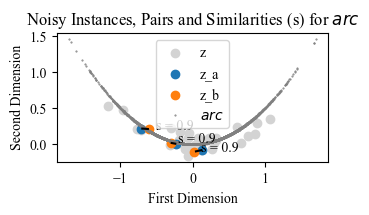

In [3]:
# Configuration
gtds.reset_random_number_generators(seed=953) # Reproducability
M = 2**12; N = 2 # Instance count, dimension count

# Generate points along a line
S = np.random.normal(loc=0.0, scale=0.5, size=[M]) # initial data structure, used to synthesize model input and target

# Set up the raw manifold function, i.e. before noise
manifold_function = lambda S: (S, 0.5*np.pow(S,2)) # Maps S to arc

# Generate a dataset
noise_standard_deviation = [0.1, 0.1] # for horizontal and vertical dimension, respectively
Z, Y = gtds.create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
print("The model input Z has shape [instance count M, dimension count N] =", Z.shape)
print('The first 3 examples of Z are'); print(Z[:3,:])
print("\nThe variable Y used to set up the pair-sampler has shape [instance count M, factor count F] =", Y.shape)

# Generate an iterator that samples correlated pairs
target_correlations = [0.0, 0.9] # For residual- and position-factor, respectively
batch_size = 2**5
iterator = gtds.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Take an example batch
(Z_a, Z_b), Y_ab  = next(iterator)
print('\nThe pairs Z_a and Z_b both have shape [batch_size, dimension count N] =', Z_a.shape, ",", Z_b.shape)
print('The correlation matrix has shape [batch_size, factor count F] =', Y_ab.shape)
print('The first 3 y_ab entries are'); print(Y_ab[:3,:].numpy())

# Plot pairs of instances
manifold_name = 'arc'
gtp.plot_instance_pairs(S=S, Z_a=Z_a, Z_b=Z_b, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)


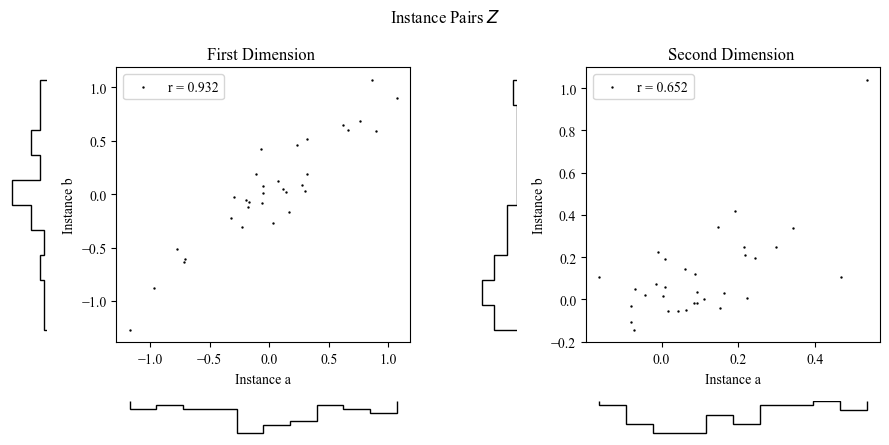

In [4]:
gtp.plot_instance_pairs_2(Z_a=Z_a, Z_b=Z_b)

### Designing a flow model
The flow model demonstrated here will be a sequence of stages and each stage will consist of activation normalization, reflection and coupling layers. We will not spend much time during this tutorial explaining how the layers work but you can learn more about them on the accompanying documentation website of Gyoza or in the following tutorials.

In [5]:
def create_model(stage_count: int) -> gmfl.FlowModel:
    
    # Prepare a sequence of layers
    layers = [None] * (6*stage_count+1)
    
    # Start with a normalization layer
    layers[0] = gmfl.ActivationNormalization(axes=[1], shape=[N])
    
    for i in range(stage_count):
        
        # Reflection layer, flips point cloud about a hyperplane
        layers[6*i+1] = gmfl.Reflection(axes=[1], shape=[N], reflection_count=1)

        # Coupling block, stretches some regions of space more than others
        # Couple first half of dimensions, 
        mask_1 = gmm.CheckerBoard(axes=[1], shape=[N]) # We need to mask out half of the dimensions
        compute_coupling_parameters_1 = tf.keras.Sequential(layers=[tf.keras.layers.Dense(units=4*N, activation='relu'), tf.keras.layers.Dense(units=N, activation=None)]) # We use half of the dimensions to compute coupling parameters to be added to the other half of the dimension
        layers[6*i+2] = gmfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1) # This layer applies the mask, computes the coupling parameters and adds them to the other half of dimensions
        layers[6*i+3] = gmfl.CheckerBoard(axes=[1], shape=[N]) # This layer permutes the dimensions in line with the previously chosen mask

        # Couple second half of dimensions
        compute_coupling_parameters_2 = tf.keras.Sequential(layers=[tf.keras.layers.Dense(units=4*N, activation='relu'), tf.keras.layers.Dense(units=N, activation=None)])
        mask_2 = gmm.CheckerBoard(axes=[1], shape=[N])
        layers[6*i+4] = gmfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2)
        layers[6*i+5] = gmfl.CheckerBoard(axes=[1], shape=[N])

        # End with another normalization layer
        layers[6*i+6] = gmfl.ActivationNormalization(axes=[1], shape=[N])
    
    # Construct the network
    flow_model = gmfl.FlowModel(layers) # Essentially a keras Sequential model with the added benefit of computing the jacbian determinant and inverse of the overall flow
    flow_model.build(input_shape=[M, N]) # Pass a symbolic tensor through the model to help the tensorflow backend register all computations

    # Outputs
    return flow_model

# Reproducability
gtds.reset_random_number_generators(seed=123)

# Construct flow model
flow_model = create_model(stage_count=2)
flow_model.summary()

Model: "flow_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ activation_normalization        │ [(None, 2), (None)]    │             4 │
│ (ActivationNormalization)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reflection (Reflection)         │ [(None, 2), (None)]    │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ additive_coupling               │ [(None, 2), (None)]    │            42 │
│ (AdditiveCoupling)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ checker_board_1 (CheckerBoard)  │ [(None, 2), (None)]    │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ additive_coupling_1             │ [(None, 2), (None)]    │            42 │
│ (AdditiveCoupling)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ checker_board_3 (CheckerBoard)  │ [(None, 2), (None)]    │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_normalization_1      │ [(None, 2), (None)]    │             4 │
│ (ActivationNormalization)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reflection_1 (Reflection)       │ [(None, 2), (None)]    │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ additive_coupling_2             │ [(None, 2), (None)]    │            42 │
│ (AdditiveCoupling)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ checker_board_5 (CheckerBoard)  │ [(None, 2), (None)]    │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ additive_coupling_3             │ [(None, 2), (None)]    │            42 │
│ (AdditiveCoupling)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ checker_board_7 (CheckerBoard)  │ [(None, 2), (None)]    │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_normalization_2      │ [(None, 2), (None)]    │             4 │
│ (ActivationNormalization)       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200 (1.50 KB)

 Trainable params: 184 (1.44 KB)

 Non-trainable params: 16 (64.00 B)

The tutorial module of gyoza provides a plotting function that shows the input $Z$ and the output $\tilde{Z}$ of the model. It works by drawing a small sample from $Z$. Each point receives its own color from a rainbow-pallette and is plotted in a scatter plot with a grid in the background. Then, the plotting function passes the data points and the intersection points of the background grid through the flow model. It then plots the output in a second scatter plot to show the morphing of space. You can see the plot for the uncalibrated flow model below. We set the random seed to get a consistent sample drawn from $Z$ which will allow a strcutured comparison with the output of the calibrated model later on.

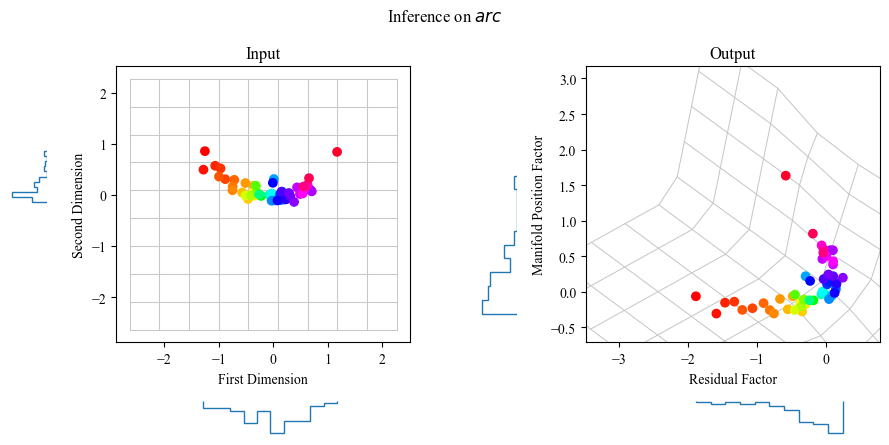

In [6]:
# Plot input and output
gtds.reset_random_number_generators(seed=9523)
gtp.plot_input_output(flow_model, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)


## Model Calibration

### Learning Objective
We will calibrate our flow model by using a maximum likelihood procedure which rests on the idea that the most probable model $T$ given the data is the model that maximizes the probability (also called likelihood) $P(Z_a, Z_b| T)$ of the data. The data points have a complicated probability distribution (i.e. manifold) in the space of $Z$ and we want to use our flow model $T$ to simplify it, i.e. morph the manifold to something that expresses our factors of interest more clearly. In line with the change of variables formula from probability theory, we will need to adjust the probability estimates using the Jacobian determinant, which is a measure of how strong space was stretched by $T$ around each data point. Then, we are free to constrain the manifold of the output space $\tilde{Z}$ to
- be normally distributed along all dimensions and
- arrange instances in such a way that our output pairs ($\tilde{Z}_a,\tilde{Z}_b$) are correlated along certain dimensions that we assign to each factor. Here, we assign one dimension to the residual factor and one to the position factor.

We then measure to what extent the model's output pairs $\tilde{Z}_a, \tilde{Z}_b$ are distributed according to these criteria. Any deviation from optimum is considered a loss and we use the gradient descent algorithm to iteratively tweak the model parameters until they transform $Z$ to the optimal $\tilde{Z}$ according. The loss function is defined in Gyoza and is called [SupervisedFactorLoss](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html#gyoza.modelling.losses.SupervisedFactorLoss). For a more rigorous explanation of this optimization procedure, refer to the paper by Esser et al. in 2020 [[4](#References)].

### Model Fitting
To fit our model, we will need to pass both instances $Z_a, Z_b$ through the flow model $T$ and get the Jacobian determinants for each of them. We then pass these results to the loss function together with an indication for how similar the pairs are for each factor. Remember, these are simply the target correlations we used earlier to set up our pair-sampler. We will use tensorflow's functional workflow to specify the steps of computation. As an alternative, you could also use tensorflow's eager-execution workflow by subclassing FlowModel and overriding the default train_step method.

In [16]:
# Reproducibility 
gtds.reset_random_number_generators(seed=123)

# Build a wrapper using tensorflow functional API
input_a = tf.keras.layers.Input(shape=(N,), name="z_a")
input_b = tf.keras.layers.Input(shape=(N,), name="z_b")

z_tilde_a, j_a = flow_model(input_a)
z_tilde_b, j_b = flow_model(input_b)

outputs = tf.keras.layers.Concatenate(axis=-1)([z_tilde_a, z_tilde_b, tf.keras.ops.reshape(j_a, (-1,1)), tf.keras.ops.reshape(j_b, (-1,1))]) # Concatenate them so they arrive as one 'y_pred' in the loss function
pair_model = tf.keras.Model(inputs=[input_a, input_b], outputs=outputs)

# Compile and Train
loss_function = gml.SupervisedFactorLoss(dimensions_per_factor=[1,1]) # 1 dimension for the residual factor, 1 for the position factor
pair_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=loss_function)
history = pair_model.fit(iterator, steps_per_epoch=100, epochs=50)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -4.0077
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.2885
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.2519
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1872
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.2595
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1008
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1683
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1809
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1827
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1997
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.0247
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.2588
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.2523
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -4.1005
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s

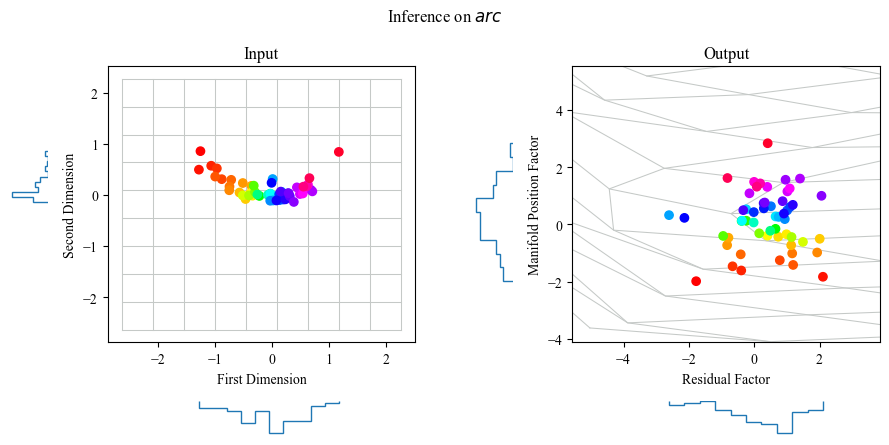

In [8]:
gtds.reset_random_number_generators(seed=9523)

# Plot input and output
gtp.plot_input_output(flow_model, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)


In [9]:
flow_model.variables[1]

<Variable path=activation_normalization/_scale_, shape=(2,), dtype=float64, value=[0.54403053 0.30880281]>

## Model Inference

After the model is calibrated, it can be used for inference in both directions, i.e. to map a $Z$ point to $\tilde{Z}$ or vice versa. In the below demo, we also show an interactive tool that allows to tweak the residual and the position factor in the $\tilde{Z}$ space independently and see how the inversion maps to $Z$.

In [10]:
# Forward inference
print("The input to the flow model has shape (instance count, width, height, channel count): ", Z_a.shape)
Z_a_tilde, _ = flow_model(Z_a)
print("The output of the flow model has shape (instance count, width, height, channel count): ", Z_a_tilde.shape)

# Inverse inference
Z_a_predicted = flow_model.invert(Z_a_tilde)
print("The reconstructed input has shape (instance count, width, height, channel count): ", Z_a_predicted.shape)
error = np.round(np.sum(np.pow(Z_a_predicted-Z_a, 2)), 2)
print("The sum of squared errors between Z_tilde_a and its reconstruction is", error)

The input to the flow model has shape (instance count, width, height, channel count):  (32, 2)
The output of the flow model has shape (instance count, width, height, channel count):  (32, 2)
The reconstructed input has shape (instance count, width, height, channel count):  (32, 2)
The sum of squared errors between Z_tilde_a and its reconstruction is 0.0


In [ ]:
# Plot interactive tool
from ipywidgets import interact, fixed
interact(gtp.plot_inverse_point, position=(-2.0, 2.0, 0.1), residual=(-2.0,2.0,0.1), S=fixed(np.random.choice(a=S, size=[batch_size], replace=False)), network=fixed(flow_model), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

interactive(children=(FloatSlider(value=0.0, description='position', max=2.0, min=-2.0), FloatSlider(value=0.0…

<function gyoza.tutorials.plotting.plot_inverse_point(position: float, residual: float, S: numpy.ndarray, network: gyoza.modelling.flow_layers.FlowModel, manifold_function: Callable, manifold_name: str)>

## Saving and Loading

In order to store and distribute a model in Gyoza, one needs to save its trainable parameters. **Important:** Since not all flow_layers are serializable by the regular [tensorflow](https://www.tensorflow.org/tutorials/keras/save_and_load) protocol it is only possible to save the model parameters but not the entire model. It is thus recommended to wrap the code for model creation in a function that can be called to construct a new model with the same architecture. That new model can then be loaded with the weights that were saved previously. 

In [15]:
# Save existing model
path = "example_model.weights.h5"
flow_model.save_weights(path)

# Initialize a new instance of same architecture
new_flow_model = create_model(stage_count=2)

# Load weights
new_flow_model.load_weights(path); 
os.remove(path) # The file is no longer needed and deleted to prevent clutter

# Compare
Z_tilde_a_old, j_a_old = flow_model(Z_a)
Z_tilde_a_new, j_a_new = new_flow_model(Z_a)
print("The saved and the loaded model weights produce a Z_a prediction difference equal to", tf.reduce_sum((Z_tilde_a_old-Z_tilde_a_new)**2).numpy())
print("The saved and the loaded model weights produce a j_a prediction difference equal to", tf.reduce_sum((j_a_old-j_a_new)**2).numpy())

The saved and the loaded model weights produce a Z_a prediction difference equal to 0.0
The saved and the loaded model weights produce a j_a prediction difference equal to 0.0


## Next Steps
This was a tutorial on how to use the gyoza modelling framework for flow layers. There are actual experiments performed with gyoza on [GitHub](https://github.com/TimHenry1995/gyoza/tree/main).

## References

[1] ["Variational Inference with Normalizing Flows" by Danilo Jimenez Rezende and Shakir Mohamed](https://arxiv.org/abs/1505.05770)

[2] ["Glow: Generative Flow with Invertible 1×1 Convolutions" by Diederik P. Kingma, Prafulla Dhariwal](https://arxiv.org/abs/1807.03039)

[3] ["DENSITY ESTIMATION USING REAL NVP" by Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio](https://arxiv.org/abs/1605.08803)

[4] ["A Disentangling Invertible Interpretation Network for Explaining Latent Representations" by Patrick Esser, Robin Rombach, Björn Ommer](https://arxiv.org/abs/2004.13166)

[5] ["Learning disentangled representations in the imaging domain" by Xiao Liu, Pedro Sanchez, Spyridon Thermos, Alison Q. O'Neil, Sotirios A. Tsaftaris](https://arxiv.org/abs/2108.12043)